# Practical session: Interpretability in Machine learning

Machine learning algorithms often behave as black boxes.  
In this practical session, we will see some tools to gain interpretability on our models.
In the first part of this session, we will focus on model agnostic methods.  
In the second part, we will concentrate on techniques for neural network models.  

## Model agnostic Methods

Before starting with a simple regression problem, run the code below to install compatible versions of pandas and pandas profiling which we will be using to explore our data.

In [ ]:
!pip install pandas-profiling==2.8.0 > /dev/null 2>&1
!pip install pandas==0.25 > /dev/null 2>&1
!pip install numpy==1.16.5 > /dev/null 2>&1

#Restart the runtime after executing the cell above 

### Dataset

We will begin with a simple regression problem of predicting Californian houses' house prices according to 8 numerical features.  
Scikit-learn provides the dataset, and a full description is available [here](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).


In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
feature_names = cal_housing.feature_names
X = pd.DataFrame(cal_housing.data, columns=feature_names)
y = cal_housing.target
X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

I encourage you to explore the dataset by yourself using pandas and seaborn; it is always a good exercise.  
Nonetheless, today's practical session is not designed to train the best possible models but to learn how to interpret them.  
It may be a good opportunity to present you a friendly tool for exploring datasets: [Pandas profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/).  
Pandas profiling provides an automatic data exploration tool and html reports in a one-liner.  
I would recommend usually doing it by yourself in other projects, but it may still be helpful for having a quick overview of what your dataset looks like.

In [2]:
from pandas_profiling import ProfileReport

ProfileReport(X, sort="None")
# if this cell returns an error restart the kernel and re-run the previous cells

TypeError: ignored

Now use scikit-learn's ```train_test_split``` method to split your dataset in train and test (10%)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

Train a linear regression, a random forest and a neural network to predict the houses price.  
Use a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to create a model that performs both the scaling and the training algorithm.  
Test all models on your test set to copare their performances.  
Feel free to train and test more sophisticated models such as XGBoost, LightGBM...

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

lr = make_pipeline(StandardScaler(),LinearRegression())

rf =  make_pipeline(StandardScaler(),RandomForestRegressor())


mlp =  make_pipeline(StandardScaler(),MLPRegressor())

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# ... #test your models

lr.score(X_test, y_test)
rf.score(X_test, y_test)
mlp.score(X_test, y_test)



0.7854556117582719

Linear models are considered intrinsically interpretable.  
Using the ```coef_``` attribute of your model, visualize the importance of each of the features of the linear model.  

In [5]:
# to access the model part of your pipeline: lr[1]

lr[1].coef_

array([ 0.82964723,  0.11818985, -0.27519985,  0.31672284, -0.00176468,
       -0.03976045, -0.89102087, -0.8641399 ])

### Features importance

We will begin by looking at the features importance.  
Scikit-learn implements some native methods to compute the feature importance of tree-based methods.  
We will use an external library called [Eli5](https://eli5.readthedocs.io/en/latest/overview.html#features) to compute the feature permutation method, which is model agnostic and can thus be applied to our three models.



In [6]:
!pip install eli5 > /dev/null 2>&1

Use the ```PermutationImportance``` to compute the features importance of your models.  (Documentation [here](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)).  
Plot them for each of your model.  
Are the feature importance of the linear model similar to the coefficients?
Are the features as important for all your models?  
Create a dictionnary containing the top 5 features for each of your model (**key**:model name, **value**: dataframe of features importance)

In [8]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns

features_importance_dict = {}
for model, name in zip([lr, rf, mlp], ['logistic regression', 'random forest', 'multi layer perceptron']):
  plt.figure()
  permumtation_import = PermutationImportance(model).fit(X_test,y_test)
  features_importance = {'Feature_name':feature_names, 'Importance':permumtation_import.feature_importances_} 
  features_importance = pd.DataFrame(features_importance) # dataframe containing the features names and their importance
  # print(features_importance)
  features_importance = features_importance.sort_values(by='Importance',ascending=False) # sort the dataframe by feature importance
  features_importance_dict[name] = features_importance #add the dataframe to your dictionnary
  ax = sns.barplot(x='Feature_name', y='Importance', data=features_importance) #plot the model's features importance
  plt.title(name)

You may have noticed that the geographical position seems to be among the most important features for some of your models.  
We can use [folium](http://python-visualization.github.io/folium/)
 to plot these on a map and get a better overview.

In [9]:


import folium

latmean = X.Latitude.mean()
lonmean = X.Longitude.mean()
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

def color(value): 
    if value in range(0,149999): 
        col = 'green'
    elif value in range(150000,249999): 
        col = 'yellow'
    elif value in range(250000,349999): 
        col = 'orange'
    else: 
        col='red'
    return col 
      
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

# Top three smart phone companies by market share in 2016
for lat,lan,value in zip(X_test['Latitude'][:300],X_test['Longitude'][:300],y_test[:100]*100000): 
    folium.Marker(location=[lat,lan],icon= folium.Icon(color=color(value),icon_color='black',icon = 'home')).add_to(map) 
map



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: color argument of Icon should be one of: {'green', 'blue', 'red', 'pink', 'lightgray', 'white', 'gray', 'lightred', 'lightgreen', 'lightblue', 'orange', 'darkblue', 'darkred', 'cadetblue', 'beige', 'purple', 'darkpurple', 'black', 'darkgreen'}.


### PDP and ICE plots

We will use the [pdpbox](https://pdpbox.readthedocs.io/en/latest/) library to generate our PDP and ICE plots.

In [10]:
!pip install pdpbox > /dev/null 2>&1

The following code shows you how to produce a PDP plot for the random forest model.  
```python
from pdpbox import pdp, get_dataset, info_plots

pdp_feat = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=feature_names, feature='MedInc')

pdp.pdp_plot(pdp_feat, 'MedInc', plot_lines=True, frac_to_plot=0.5)
plt.show()
```
Use it to generate the PDP plots for the three most important features of each of your models.  
What is the nature of their relationship with the target?


In [11]:
from pdpbox import pdp, get_dataset, info_plots
model = rf #lr, mlp
model_name = 'random forest'#'logistic regression' , 'multi layer perceptron'

top_3_features = features_importance_dict[model_name].Feature_name[:3].values
print(top_3_features)
for i, feature in enumerate(top_3_features, 1):
  pdp_feat = pdp.pdp_isolate(model,dataset=X_test,model_features=feature_names,feature=feature)

  pdp.pdp_plot(pdp_feat,feature,plot_lines=True, frac_to_plot=0.5)
  plt.show()



['MedInc' 'Latitude' 'Longitude']


It is also possible to visualize the combined effetc of two features:

In [12]:
features_to_plot = ['Latitude', 'Longitude']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

Scikit-learns also provides methods to generate such plots, but may offer less flexibility.

In [13]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

for model, model_name in zip([lr, rf, mlp], ['logistic regression', 'random forest', 'multi layer perceptron']):

  top_3_features = features_importance_dict[name].Feature_name[:3].values
  display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_3_features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
    )
  display.figure_.suptitle(f"Partial dependence for {model_name} model")
  display.figure_.subplots_adjust(hspace=0.3)

In [14]:
for model, name in zip([lr, rf, mlp], ['logistic regression', 'random forest', 'multi layer perceptron']):
  _, ax = plt.subplots(ncols=3, figsize=(9, 4))
  top_2_features = features_importance_dict[name].Feature_name[:3].values
  features = [top_2_features[0], top_2_features[1], (top_2_features[0], top_2_features[1])]
  display = PartialDependenceDisplay.from_estimator(
      model,
      X_test,
      features,
      kind="average",
      n_jobs=3,
      grid_resolution=20,
      ax=ax,
  )
  display.figure_.suptitle(f"Partial dependence for {name} model")
  display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

### SHAP

Previous methods provided global explanations of our models.  
We will now focus on local interpretability methods.  
We will begin with the SHAP methods based on the estimation of the Shapley values.  
The library SHAP implements the SHAP method (and many others).

Inspire yourself with the following [documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html) to produce a visualization of the estimated Shapley values of your different models, first for a single example using the ```force_plot``` method and for the entire test, dataset using the ```summary_plot``` method.

In [15]:
!pip install shap > /dev/null 2>&1

In [23]:
import shap
shap.initjs() #needed to plot results directly on the notebook

idx = 1 # index of the instance we want to explain

explainer = shap.KernelExplainer(rf.predict,shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test.iloc[idx,:])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[idx,:]) #single exemple plot
plt.figure()
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test) #Summary on the dataset. To speed up we just compute the shap values for 20 exempless

  0%|          | 0/2064 [00:00<?, ?it/s]

### Lime  

We also saw in class another model agnostic local interpretability method.    
Many implementations of the LIME method are available in python.  
In this practical session, we will use the [implementation provided by the authors](https://github.com/marcotcr/lime).  

In [25]:
!pip install lime > /dev/null 2>&1

LIME provides eay to understand an friendly looking explanations for your model predictions.  
You first need to instanciate an Explainer (in our case a ```LimeTabularExplainer```) and then call the ```explain instance``` method of the explainer to get the explanations.  

In [26]:
import lime
import lime.lime_tabular

index = 0

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=feature_names, mode="regression")
exp = explainer.explain_instance(X_test.iloc[index], rf.predict, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

#### Classification
LIME also works with classification problems.  
We will repeat the previous experiment using a different dataset for [breast cancer prediction](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset) and a decision trees algorithm.

In [27]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names
X = pd.DataFrame(breast_cancer.data, columns=feature_names)
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
473        12.27         29.97           77.42      465.4          0.07699   
102        12.18         20.52           77.22      458.7          0.08013   
272        21.75         20.99          147.30     1491.0          0.09401   
196        13.77         22.29           90.63      588.9          0.12000   
75         16.07         19.65          104.10      817.7          0.09168   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
473           0.03398         0.00000              0.00000         0.1701   
102           0.04038         0.02383              0.01770         0.1739   
272           0.19610         0.21950              0.10880         0.1721   
196           0.12670         0.13850              0.06526         0.1834   
75            0.08424         0.09769              0.06638         0.1798   

     mean fractal dimension  ...  worst radius  worst texture  \
473                 0.05960  ...         13.45          38.05   
102                 0.05677  ...         13.34          32.84   
272                 0.06194  ...         28.19          28.18   
196                 0.06877  ...         16.39          34.01   
75                  0.05391  ...         19.77          24.56   

     worst perimeter  worst area  worst smoothness  worst compactness  \
473            85.08       558.9           0.09422            0.05213   
102            84.58       547.8           0.11230            0.08862   
272           195.90      2384.0           0.12720            0.47250   
196           111.60       806.9           0.17370            0.31220   
75            128.80      1223.0           0.15000            0.20450   

     worst concavity  worst concave points  worst symmetry  \
473           0.0000               0.00000          0.2409   
102           0.1145               0.07431          0.2694   
272           0.5807               0.18410          0.2833   
196           0.3809               0.16730          0.3080   
75            0.2829               0.15200          0.2650   

     worst fractal dimension  
473                  0.06743  
102                  0.06878  
272                  0.08858  
196                  0.09333  
75                   0.06387  

[5 rows x 30 columns]

Train a decision tree (with max_depth=5) on this dataset and plot the confusion matrix on the test dataset.

In [44]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)

y_pred=dt.predict(X_test)

print("Descision Tree score:",dt.score(X_test,y_test))

Descision Tree score: 0.9298245614035088


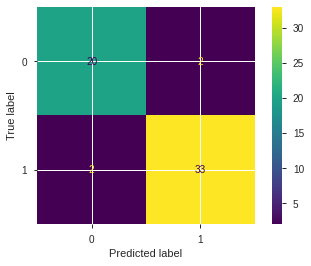

In [47]:
cm=confusion_matrix(y_test,y_pred,labels=dt.classes_)
disp=ConfusionMatrixDisplay(cm,display_labels=dt.classes_)
disp.plot()

In [46]:
%matplotlib inline

Decision trees are also interpretable models.  
Scikit-learn provides an efficient way to visualize their structure.  

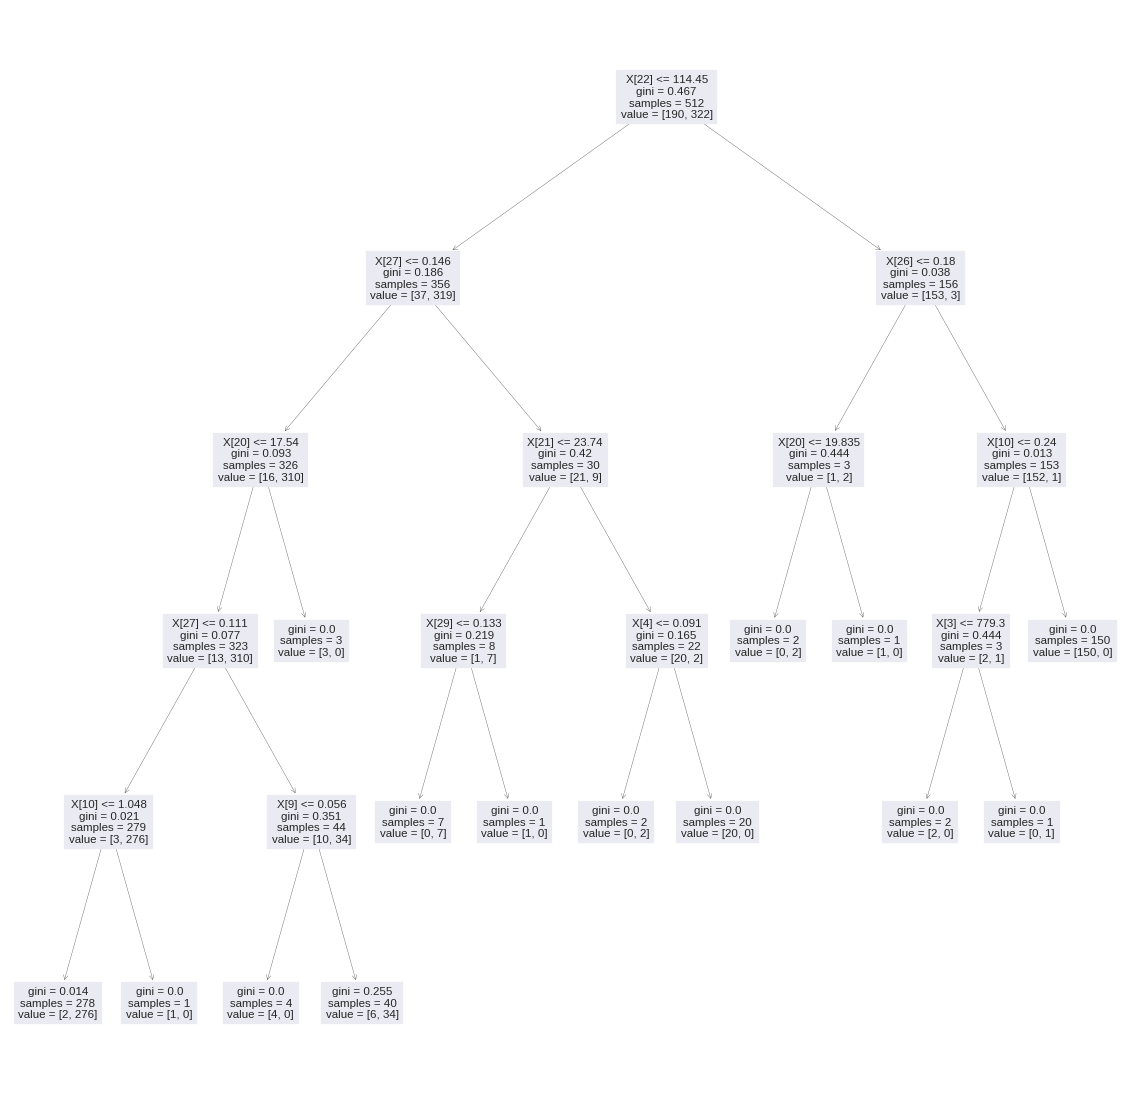

In [48]:
import matplotlib.pyplot as plt
import sklearn.tree as tree
plt.figure(figsize=(20,20))
tree.plot_tree(dt)
plt.show()

Explain the predictions of your model on some examples.  
For classification tasks, LIME needs the predicted "probailities" of the model.  
Use the ```predict_proba``` method of your classifier instead of the ```predict``` method when calling the explain instance.    
Also, don't forget to remove the ```mode="regression"``` argument when instanciating the ```LimeTabularExplainer```.  
Are the explanations consistent with the decision graph?

In [56]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),mode='regression')

In [62]:
index = 0
exp = explainer.explain_instance(X_test.to_numpy(),predict_fn=dt.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)

ValueError: ignored

#### Text data
The authors also provided nice visualizations for text data.  
We will now train a Random forest to classify whether scientific texts are about medicine or space.   
We will be using two categories from the [newsgroup dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) available in scikit-learn.

In [63]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'sci.med',
    'sci.space'
]


train_data = fetch_20newsgroups(subset='train', categories=categories)
test_data = fetch_20newsgroups(subset='test', categories=categories)

class_names = train_data.target_names

X_train, y_train  = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target

Here is an example of text to classify:

In [64]:
X_train[0]

'From: flb@flb.optiplan.fi ("F.Baube[tm]")\nSubject: Vandalizing the sky\nX-Added: Forwarded by Space Digest\nOrganization: [via International Space University]\nOriginal-Sender: isu@VACATION.VENARI.CS.CMU.EDU\nDistribution: sci\nLines: 12\n\nFrom: "Phil G. Fraering" <pgf@srl03.cacs.usl.edu>\n> \n> Finally: this isn\'t the Bronze Age, [..]\n> please try to remember that there are more human activities than\n> those practiced by the Warrior Caste, the Farming Caste, and the\n> Priesthood.\n\nRight, the Profiting Caste is blessed by God, and may \n freely blare its presence in the evening twilight ..\n\n-- \n* Fred Baube (tm)\n'

Let's train a random forest to classify our dataset.

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline

model = make_pipeline(
        CountVectorizer(max_df= 0.5, ngram_range= (1, 2)),
        TfidfTransformer(),
        RandomForestClassifier()
)

model.fit(X_train, y_train)
print(f"Model score: {model.score(X_test, y_test):.2f}")

Model score: 0.93


We will use a specific ```LimeTextExplainer``` to explain the predictions.

In [66]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [67]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

index = 11
exp = explainer.explain_instance(X_test[index], model.predict_proba, num_features=6)

prediction = model.predict_proba([X_test[index]])
class_predicted = class_names[prediction.argmax(1)[0]]
class_proba = prediction.max(1)[0]
true_class = class_names[y_test[index]]
print(f'Class predicted: {class_predicted} (p={class_proba})')
print(f'True class: {class_names[y_test[index]]}')

Class predicted: sci.space (p=0.89)
True class: sci.space


Here are the top words used by the classifier.  

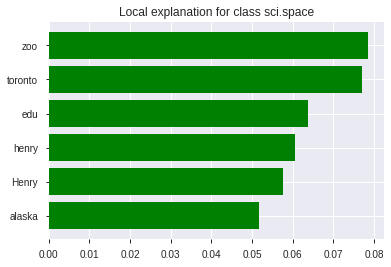

In [68]:
fig = exp.as_pyplot_figure()

These explanations seem plausible, let's visualize these words in their context:

In [69]:
exp.show_in_notebook(text=True)

Some of the words are in the newsgroup header!  
Would you trust such a classifier?

Scikit-learn provides an option to remove all headers and footers.  
Train a new model on the datset with removed headers and footers and comare its F1-score with the previous model.

In [70]:
train_data = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'),
                                     categories=categories)
X_train, y_train  = train_data.data, train_data.target



model = make_pipeline(
        CountVectorizer(max_df= 0.5, ngram_range= (1, 2)),
        TfidfTransformer(),
        RandomForestClassifier()
)

model.fit(X_train, y_train)

print(f"Model score: {model.score(X_test, y_test):.2f}")

Model score: 0.85


Now visualize the explainations computed by lime on the same example with your new model.  
Which of the two models would you trust the more?

Class predicted: sci.space (p=0.7165625)
True class: sci.space


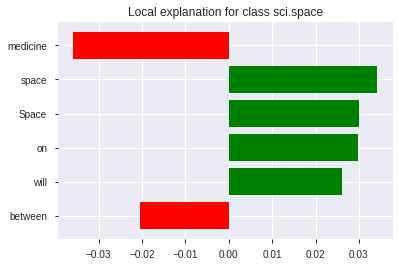

In [72]:
explainer = LimeTextExplainer(class_names=class_names)
index = 11
exp = explainer.explain_instance(X_test[index], model.predict_proba, num_features=6)
prediction = model.predict_proba([X_test[index]])
class_predicted = class_names[prediction.argmax(1)[0]]
class_proba = prediction.max(1)[0]
true_class = class_names[y_test[index]]
print(f'Class predicted: {class_predicted} (p={class_proba})')
print(f'True class: {class_names[y_test[index]]}')

fig = exp.as_pyplot_figure()


#### Image Data

Finally, LIME also provides friendly-looking visualizations on images.  
We will use a subset of Imagenet to test these visualizations.


In [73]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar zxvf imagenette2.tgz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n

In [74]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
from torch.utils.data import Dataset

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def get_imagenette2_loaders(root_path='./imagenette2', **kwargs):

    trainset = torchvision.datasets.ImageFolder(os.path.join(root_path, "train"), transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, **kwargs)
    testset = torchvision.datasets.ImageFolder(os.path.join(root_path, "val"), transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, **kwargs)
    return trainloader, testloader

trainloader, testloader = get_imagenette2_loaders( batch_size=64, shuffle=True, num_workers=2)

labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

(-0.5, 1809.5, 453.5, -0.5)

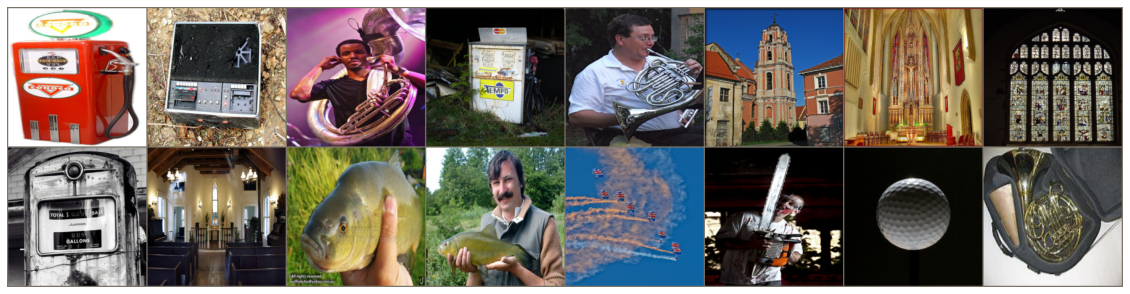

In [75]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

x, _ = next(iter(trainloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

We will train a neural network to classify these images.  
However, training neural networks on high-definition images may be long and difficult.  
We will use a pre-trained VGG11 and replace the fully connected part of the network to match the ten classes (this is called transfer learning).  
Complete the following code to instantiate a model predicting among ten classes with pre-trained features. 

In [76]:
import torch.nn as nn
import torch

model = torchvision.models.vgg11(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [83]:
for param in model.features:
    param.requires_grad = False #we freeze the feature extraction part of the network

model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(64),
            nn.Dropout(0.5),
            nn.Softmax(10)
        )

model = model.cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Fill the following code to implement the training loop.

In [85]:
from tqdm import tqdm

criterion_classifier = nn.CrossEntropyLoss(reduction='mean')

def train(model, optimizer, trainloader, epochs=30):
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        for x, y in trainloader:
            loss = 0
            x = x.cuda()
            y = y.cuda()
            y_hat = model.compile(loss='binary_crossentropy',
                                  optimizer=optimizer,metrics=['accuracy'])

            loss += criterion_classifier(y_hat)
            _, predicted = y_hat.max(1)
            corrects += predicted.eq(y).sum().item()
            total += y.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'epoch:{epoch} current accuracy:{round(corrects / total * 100, 2)}%')
    return (corrects / total)

Train your model. One or two epochs should be enough since we are using transfer learning.

In [86]:
learning_rate = 5e-3
epochs = 1
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model,otpimizer,trainloader,epochs=epochs)

ValueError: ignored

Test your network to validate it has enough classification abilities.

In [ ]:
def test(model, dataloader):
    test_corrects = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x).argmax(1)
            test_corrects += y_hat.eq(y).sum().item()
            total += y.size(0)
    return test_corrects / total

model.eval()
test_acc = test(model, testloader)
print(f'Test accuracy: {test_acc:.2f} %')

Using a single example, we will now use lime to visualize the important parts of the image for our model prediction.

In [ ]:
idx = 0

img = inv_normalize(x[idx])
np_img = np.transpose(img.cpu().detach().numpy(), (1,2,0))*255
np_img = np_img.astype(np.uint8)
plt.imshow(np_img)
plt.axis('off')

Let's first verify our model prediction:

In [ ]:
input = x[idx].unsqueeze(0).cuda()
output = model(input)
_, prediction = torch.topk(output, 1)
print(f"Model's prediction: {labels[prediction.item()]}")

LIME provide a ```LimeImageExplainer``` to deal with images.
However, the  ```LimeImageExplainer``` requires a callable function that will directly produce predictions for a list of images (the perturbed from the original images) in the form of a numpy array.  
Our pytorch model works with pytorch ```Tensor``` mini-batches and outputs ```Tensor``` objects.  
We thus need to wrap our model and the associated pre-processing into a single callable function to use the ```LimeImageExplainer```.

In [ ]:
import torch.nn.functional as F

lime_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def batch_predict(images):
  with torch.no_grad():
    model.eval()
    batch = torch.stack(tuple(lime_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch = batch.to(device)
    logits = model(batch)
  return logits.detach().cpu().numpy()

We now can use the Lime explainer to visualize which parts of the images were the most important.

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np_img, 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)

## Model specific methods
We just saw many methods for model agnostic interpretability.  
The second part of this session is dedicated to model-specific methods.  
In particular, we will implement methods specific to neural networks.

### Vanilla gradient back-propagation

We will now implement three methods to generate saliency maps on our images.  
One of the simplest ways to generate saliency maps is certainly to backpropagate the gradients of the predicted output directly to the image input.  This method, called vanilla gradient backpropagation, is presented in this [article](Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps).

Let's first visualize an image for which we will generate a saliency map according to our model's prediction.

(-0.5, 223.5, 223.5, -0.5)

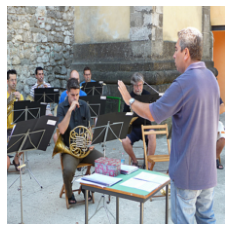

In [87]:
import numpy as np 

x, _ = next(iter(trainloader))
idx = 0

img = x[idx]
np_img = np.transpose(inv_normalize(img).cpu().detach().numpy(), (1,2,0))
plt.imshow(np_img)
plt.axis('off')

By default, input tensors do not require to generate gradients in Pytorch.  
Thus, we first need to set the image to catch the gradient during the backward pass.

In [88]:
img = img.unsqueeze(0).cuda() # we need to set the input on GPU before the requires_grad operation!
img.requires_grad_();

We will now compute the model's prediction for this image and backpropagate from this prediction to the image.

In [89]:
output = model(img)
output_idx = output.argmax()
output_max = output[0, output_idx]

output_max.backward()

IndexError: ignored

We can now generate a saliency map were important pixels will correspond to important gradients!

In [ ]:
saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')


Try with different images.

In [ ]:
...

### Smooth grad
A simple way to generate smoother visualizations called [Smooth-grad](https://arxiv.org/pdf/1706.03825.pdf) consists of averaging saliency maps from augmented versions of the original image.  
Complete the following function to generate the gradient of an image according to the model's prediction.

In [ ]:
def get_vanilla_grad(img, model):
  ...#retain gradients
  ...

  return img.grad

We will now generate perturbated versions of the image by adding a gaussian noise to the original image.  
For every image generated we will compute the corresponding gardients and average them to generate the final saliency map.

In [ ]:
import numpy as np

stdev_spread=0.15
n_samples=100
stdev = stdev_spread * (img.max() - img.min())
total_gradients = torch.zeros_like(img, device='cuda')

for i in range(n_samples):
    noise = np.random.normal(0, stdev.item(), img.shape).astype(np.float32)
    noisy_img = img + torch.tensor(noise, device='cuda', requires_grad=True)
    grad= get_vanilla_grad(noisy_img, model)
    total_gradients += grad * grad #using the square of the gradients generates smoother visualizations
    #total_gradients += grad
total_gradients /= n_samples

saliency, _ = torch.max(total_gradients.abs(), dim=1) 
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')

Try it with other images.

In [ ]:
...

### Grad-CAM
Instead of propagating the gradients to the inputs, the [Grad-CAM](https://arxiv.org/abs/1610.02391) method generates a saliency map by multiplying the outputs of the final feature map with an average of its gradients.  It thus generates coarse saliency maps, sometimes more relevant than pixels.  
We will create a 'hook' to keep both the activations and the gardients of a network layer.  
This operation is a bit tricky, just keep it mind that it is a way to keep activations and gradients in a single object during the forward and the backward pass.

In [90]:
class HookFeatures():
    def __init__(self, module):
        self.feature_hook = module.register_forward_hook(self.feature_hook_fn)
    def feature_hook_fn(self, module, input, output):
        self.features = output.clone().detach()
        self.gradient_hook = output.register_hook(self.gradient_hook_fn)
    def gradient_hook_fn(self, grad):
        self.gradients = grad
    def close(self):
        self.feature_hook.remove()
        self.gradient_hook.remove()

We will 'hook' the activations and gradients of the last convolutional layer.

In [91]:
print(model)
hook = HookFeatures(model.features[19])

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Similar to what we did before, we will backpropagate the gradients of the predicted output on the feature map this time and get both the activations and the gradients thanks to our hook on the last convolutional layer.

In [92]:
output = model(img)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

gradients = hook.gradients
activations = hook.features
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i] # we multiply every chanels of the feature map with their corresponding averaged gradients

IndexError: ignored

We can now take the average of all channels of the gradient weighted feature map to generate a heat map, keeping only the positive values to get the positive influences only.  
We also need to reshape the generated heat map to math the original input size.

In [ ]:
import cv2

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap.detach().cpu(), 0)
heatmap /= torch.max(heatmap)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[2], img.shape[3]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
superposed_img = (heatmap) * 0.4 + np_img 
plt.figure(figsize=(8,8))
plt.imshow(np.clip(superposed_img,0,1))
plt.axis('off')

We must remove our hook, it won't be used in the rest of the session.

In [ ]:
hook.close()

### Captum  

[Captum](https://captum.ai/)  is a library developed by Facebook to generate explanations on Pytorch models.  
It implements various other saliency maps methods that we did not cover during our class. 
You should look at the doc and find out [other possible methods](https://captum.ai/docs/algorithms) to gain interpretability in your Pytorch models.  
We will quickly try some of them so you know how to use them if you need to.

In [ ]:
!pip install captum

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [ ]:
def plot_heatmap(attributions, img):
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(inv_normalize(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap='hot',
                              show_colorbar=True)

# Integradted gradients (https://arxiv.org/abs/1703.01365) 
integrated_gradients = IntegratedGradients(model)
attributions = integrated_gradients.attribute(img, target=output_idx, n_steps=200, internal_batch_size=1)

plot_heatmap(attributions, img)

In [ ]:
#Noise tunnel (SmoothGrad, VarGrad: https://arxiv.org/abs/1810.03307)
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions = noise_tunnel.attribute(img, nt_samples_batch_size=1, nt_samples=10, nt_type='smoothgrad_sq', target=output_idx)

plot_heatmap(attributions, img)

In [ ]:
#Occlusion (https://arxiv.org/abs/1311.2901)
occlusion = Occlusion(model)
attributions = occlusion.attribute(img,
                                  strides = (3, 8, 8),
                                  target=output_idx,
                                  sliding_window_shapes=(3,15, 15),
                                  baselines=0)

plot_heatmap(attributions, img)

In [ ]:
#DeepLift (https://arxiv.org/pdf/1704.02685.pdf)
dl = DeepLift(model)
attributions = dl.attribute(img, target=output_idx, baselines=img * 0)

plot_heatmap(attributions, img)

In [ ]:
#Guided Grad-CAM (https://arxiv.org/abs/1610.02391)
guided_gc = GuidedGradCam(model, model.features[19])
attribution = guided_gc.attribute(img, target=output_idx)
plot_heatmap(attributions, img)

## Feature visualization
Previous methods, generating saliency maps were model-specific local-interpretability methods.  
We will now implement a global interpretability called feature visualization.  
I really encourage you to read the [distill publication](https://distill.pub/2017/feature-visualization/) presenting the methods.  The obtained visualizations are superb!
The principle of the method is straightforward. It consists of optimizing a random image to maximize the output of a neural network unit.  
A unit can be a neuron, a channel of a feature map, or an entire feature map.  
In this practical session, we will focus on channels.  
Let's first have a look at our network architecture.

In [ ]:
model

Once again, we will create a hook to keep the activation of intermediate layers.  
However, we won't need to keep the gradients this time.

In [ ]:
class FeaturesHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

The following code will compute the feature visualization for one channel of one layer.  
We begin by initializing a random image and creating a hook on the desired layer.  
Then we will do a forward pass of our image through the network and compute a loss to maximize the hooked layer's desired channel.  
We will repeat this operation several epochs. 

In [ ]:
def visualize_feature(model, layer_idx, channel_idx):
  img = torch.rand((1,3,224,224), requires_grad=True, device="cuda") #initialize a random image
  optimizer = torch.optim.Adam([img], lr=0.1, weight_decay=1e-6)
  features_hook =  FeaturesHook(model.features[layer_idx]) # hook the desired layer
  for n in range(20):  
        optimizer.zero_grad()
        model(img) #forward pass
        features_map = features_hook.features
        loss = -features_map[0, channel_idx].mean() # maximize channel's output
        loss.backward()
        optimizer.step()
        
  features_hook.close()
  img = img.squeeze(0)
  img = inv_normalize(img).cpu().detach().numpy()
  img = np.transpose(img, (1,2,0))
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  plt.axis('off')
  plt.tight_layout()

#visualize layer one channel 2 
visualize_feature(model, 1, 2)

Complete the following code to generate feature visaulizations of various filters of layer 1.

In [ ]:
layer = 1

plt.figure(figsize=(20,25))
for i, filter in enumerate(range(0, 10), 1):
  plt.subplot(5,5,i)
  ...

Try to vizsualize deeper layers (5, 9, 17 for instance)

In [ ]:
layer = 5

plt.figure(figsize=(20,25))
for i, filter in enumerate(range(0, 10), 1):
  plt.subplot(5,5,i)
  ...

In [ ]:
layer = 9

plt.figure(figsize=(20,25))
for i, filter in enumerate(range(0, 10), 1):
  plt.subplot(5,5,i)
  ...

In [ ]:
layer = 17

plt.figure(figsize=(20,25))
for i, filter in enumerate(range(0, 10), 1):
  plt.subplot(5,5,i)
  ...

Obtaining nice visualizations as in the original publication requires some additional tricks.  
Feel free to read the publication and try it on other more sophisticated networks.